In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from prml.markov_models import CategoricalHMM, GaussianHMM, Kalman

In [2]:
gaussian_hmm = GaussianHMM(
    initial_proba=np.ones(3) / 3,
    transition_proba=np.array([[0.9, 0.05, 0.05], [0.05, 0.9, 0.05], [0.05, 0.05, 0.9]]),
    means=np.array([[0, 0], [2, 10], [10, 5]]),
    covs=np.asarray([np.eye(2) for _ in range(3)]))

In [3]:
seq = gaussian_hmm.draw(100)

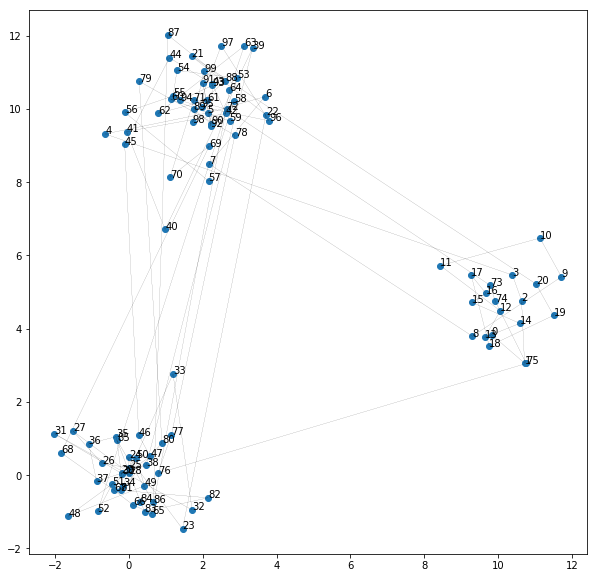

In [4]:
plt.figure(figsize=(10, 10))
plt.scatter(seq[:, 0], seq[:, 1])
plt.plot(seq[:, 0], seq[:, 1], "k", linewidth=0.1)
for i, p in enumerate(seq):
    plt.annotate(str(i), p)
plt.show()

In [5]:
posterior = gaussian_hmm.fit(seq)

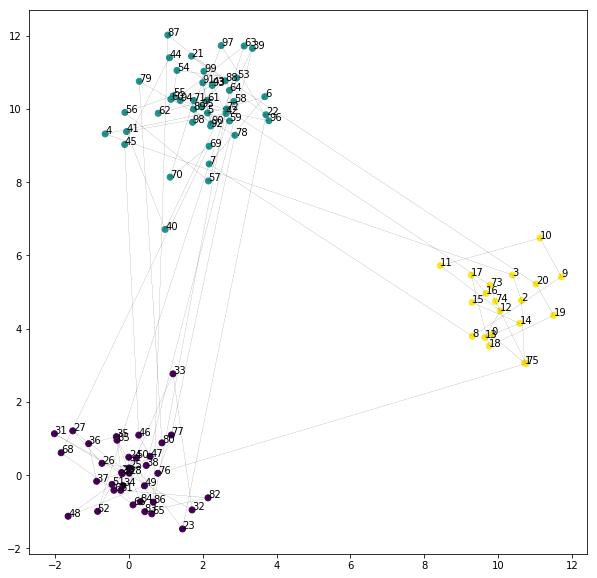

In [6]:
plt.figure(figsize=(10, 10))
plt.scatter(seq[:, 0], seq[:, 1], c=np.argmax(posterior, axis=-1))
plt.plot(seq[:, 0], seq[:, 1], "k", linewidth=0.1)
for i, p in enumerate(seq):
    plt.annotate(str(i), p)
plt.show()

In [7]:
categorical_hmm = CategoricalHMM(
    initial_proba=np.ones(2) / 2,
    transition_proba=np.array([[0.95, 0.05], [0.05, 0.95]]),
    means=np.array([[0.8, 0.2], [0.2, 0.8]]))

In [8]:
seq = categorical_hmm.draw(100)

In [9]:
posterior = categorical_hmm.forward_backward(seq)

In [10]:
hidden = categorical_hmm.viterbi(seq)

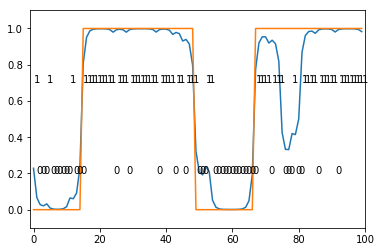

In [11]:
plt.plot(posterior[:, 1])
plt.plot(hidden)
for i in range(0, len(seq)):
    plt.annotate(str(seq[i]), (i, seq[i] / 2. + 0.2))
plt.xlim(-1, len(seq))
plt.ylim(-0.1, np.max(seq) + 0.1)
plt.show()

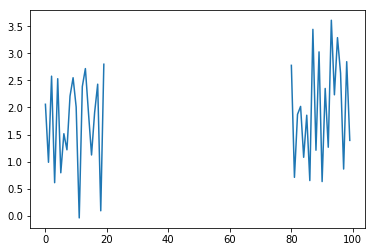

In [12]:
seq = np.zeros((100, 1)) + np.random.normal(loc=2., size=(100, 1))
seq[20:80] = np.nan
plt.plot(seq)
plt.show()

In [13]:
kalman = Kalman(
    transition=np.eye(1),
    observation=np.eye(1),
    process_noise=np.eye(1) * 0.01,
    measurement_noise=np.eye(1),
    init_state_mean=np.zeros(1),
    init_state_cov=np.eye(1) * 100)

mean, var = kalman.filtering(seq)
mean = mean.ravel()
std = np.sqrt(var).ravel()

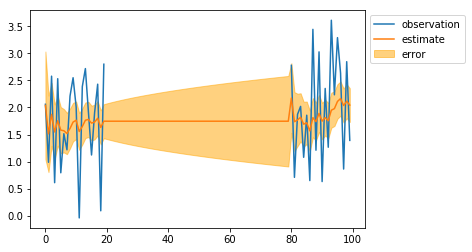

In [14]:
plt.plot(seq, label="observation")
plt.plot(mean, label="estimate")
plt.fill_between(np.arange(len(mean)), mean - std, mean + std, color="orange", alpha=0.5, label="error")
plt.legend(bbox_to_anchor=(1, 1))
plt.show()